<a href="https://colab.research.google.com/github/aminzadenoori/Airbnb_Seattle_Data_Analysis/blob/main/Airbnb_Seattle_Price_Prediction_XGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Import linear algebra and data manipulation
import numpy as np
import pandas as pd

#Import plotting packages
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error 

#Import machine learning
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

# import XGBoost
import re
import xgboost as xgb


In [10]:
#Columns in data 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Columns: 6004 entries, host_is_superhost to cancellation_policy_strict
dtypes: float64(20), int64(17), uint8(5967)
memory usage: 22.8 MB


In [ ]:
#drop not useful columns 
df=pd.read_csv("https://raw.githubusercontent.com/chaitanyakasaraneni/seattle_airbnb_dataAnalysis/master/data/listings.csv")
to_drop=['id', 'listing_url', 'name', 'summary', 'space', 'description',
       'neighborhood_overview', 'notes', 'transit', 'thumbnail_url',
       'medium_url', 'picture_url', 'xl_picture_url', 'host_id', 'host_url',
       'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_thumbnail_url', 'host_picture_url',
       'first_review', 'last_review']
df.drop(to_drop,axis=1,inplace=True)

In [11]:
#Remove $ sign and space and other chracters in values 
for c in ['cleaning_fee', 'security_deposit', 'price', 'extra_people']:
    df[c] = df[c].replace('[^a-zA-Z0-9]', '', regex=True).apply(lambda x: float(x) / 100)
#dropping constant feats  
constant_feats = []
binary_feats = []
for c in df.columns:
    if df[c].nunique() <= 1:
        constant_feats.append(c)
df.drop(constant_feats, axis=1, inplace=True)

#binary feats
binary_feats = []
for c in df.columns:   
    if df[c].nunique() == 2:
        binary_feats.append(c)

# Encode binary features
for c in ['host_is_superhost', 'host_has_profile_pic', 'host_identity_verified',
          'is_location_exact', 'instant_bookable', 
          'require_guest_profile_picture', 'require_guest_phone_verification']:
    # Fill NA with default
    df[c] = df[c].fillna('f')
    df[c] = df[c].map({'f':0, 't':1})


In [12]:
#Drop columns with more than 80% missing values
df=df.dropna(thresh=0.8,axis=1);
num_df=df.select_dtypes(exclude=['object'])

In [13]:
#Impute the missing values of the numerical columns by mean 
df[num_df.columns]=df[num_df.columns].fillna(df[num_df.columns].mean());

In [14]:
#Categorical columns preperation  by adding dummingvalues
categorical_df=df.select_dtypes(include=['object'])
for col in  categorical_df.columns:
    df = pd.concat([df.drop(col, axis=1), pd.get_dummies(df[col], prefix=col, prefix_sep='_',
                            drop_first=True, dummy_na=False)], axis=1)
#drop listing_id and year columns


In [15]:
#Prepare train and test

regex = re.compile(r"\[|\]|<", re.IGNORECASE)
df.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in df.columns.values]

X = df.drop(['price'],axis=1)

y = np.log1p(df['price'])


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3, random_state=42)


#I will train Random Forest Regressor model
# xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
                #  max_depth = 5, alpha = 10, n_estimators = 10)
xg_reg=xgb.XGBRegressor()            
xg_reg.fit(X_train,y_train)
#forest.fit(X_train, y_train.squeeze())

#calculate scores for the model
y_train_preds = xg_reg.predict(X_train)
y_test_preds = xg_reg.predict(X_test)

print('Random Forest MSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_preds),
        mean_squared_error(y_test, y_test_preds)))
print('Random Forest R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train, y_train_preds),
        r2_score(y_test, y_test_preds)))


[06:07:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Random Forest MSE train: 0.020, test: 0.029
Random Forest R^2 train: 0.787, test: 0.715


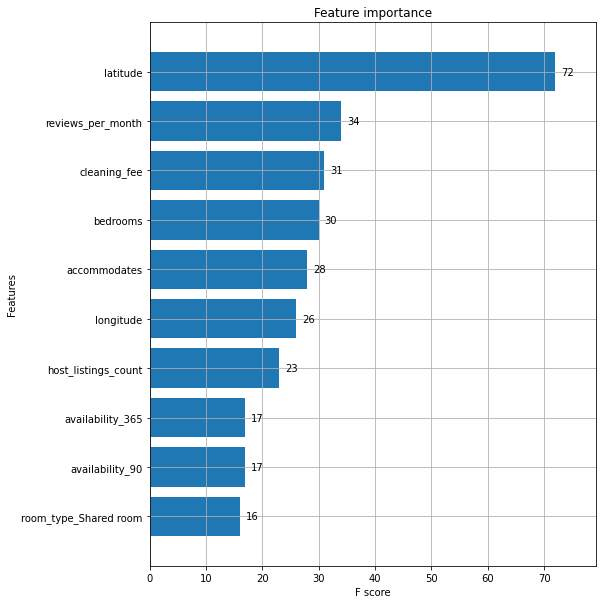

In [9]:
#Visualize the most important feartures of XGBoost
fig, ax = plt.subplots(figsize=(8, 10))
xgb.plot_importance(xg_reg, max_num_features=10, height=0.8, ax=ax)
